In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import re
import os

# --- CONFIGURAZIONE GLOBALE ---
SEQ_LEN = 30       # Fixed sequence length
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the path
save_path = 'tennis_shot_forecasting.pth'

# --- 1. DATASET (Restored & Fixed) ---
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import re
import os

class MCPTennisDataset(Dataset):
    def __init__(self, points_path, matches_path, atp_path, wta_path, max_seq_len=30):
        self.max_seq_len = max_seq_len
        
        print("Initializing Dataset (Full Version with Player IDs)...")
        
        # --- 1. Load Bio-Data (Original Handedness + New Player Vocab) ---
        try:
            # Original: Map Name -> Hand ('R'/'L')
            self.name_to_hand = self._load_handedness(atp_path, wta_path)
            # New: Map Name -> Integer ID
            self.player_vocab = {'<pad>': 0, '<unk>': 1}
            self._build_player_vocab(atp_path, wta_path)
            print(f"Bio-data loaded. Found {len(self.player_vocab)} unique players.")
        except Exception as e:
            print(f"⚠️ Warning: Could not load player bio-data ({e}). Defaulting.")        
            self.name_to_hand = {}
            
        # --- 2. Load Matches (Your Robust Loading) ---
        print(f"Loading matches: {matches_path}...")
        try:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
        except:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', quoting=3)
            
        self.match_meta = self._process_match_metadata(self.matches_df)
        
        # --- 3. Load Points (Your Robust Loading) ---
        print(f"Loading points: {points_path}...")
        try:
            self.df = pd.read_csv(points_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
        except:
            self.df = pd.read_csv(points_path, encoding='ISO-8859-1', quoting=3)
        
        # --- 4. Vocabularies ---
        self.shot_vocab = {'<pad>': 0, 'f': 1, 'b': 2, 'r': 3, 'v': 4, 'o': 5, 's': 6, 'u': 7, 'l': 8, 'm': 9, 'z': 10}
        self.zone_vocab = {'<pad>': 0, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
        self.surface_vocab = {'<pad>': 0, 'Hard': 1, 'Clay': 2, 'Grass': 3, 'Carpet': 4}
        self.hand_vocab = {'<pad>': 0, 'R': 1, 'L': 2} 
        self.score_map = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}
        
        self.samples = []
        self.sample_match_ids = [] 
        self.process_data()

    def _load_handedness(self, atp_path, wta_path):
        """Original Handedness Loader"""
        hand_map = {}
        for path in [atp_path, wta_path]:
            if not os.path.exists(path): continue
            try:
                df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
                # Create "First Last" key
                df['full_name'] = df['name_first'].str.strip() + " " + df['name_last'].str.strip()
                subset = df[['full_name', 'hand']].dropna()
                for _, row in subset.iterrows():
                    if row['hand'] != 'U': 
                        hand_map[row['full_name']] = row['hand']
                    else: 
                        hand_map[row['full_name']] = 'R'
            except: pass
        return hand_map

    def _build_player_vocab(self, atp_path, wta_path):
        """New: Builds a vocab of Name -> Integer"""
        for path in [atp_path, wta_path]:
            if not os.path.exists(path): continue
            try:
                df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
                df['full_name'] = df['name_first'].str.strip() + " " + df['name_last'].str.strip()
                for name in df['full_name'].dropna().unique():
                    if name not in self.player_vocab:
                        self.player_vocab[name] = len(self.player_vocab)
            except: pass

    def _process_match_metadata(self, df):
        """Merged Metadata Processor"""
        meta = {}
        for _, row in df.iterrows():
            m_id = row['match_id']
            
            # Robust Surface Check
            if 'Surface' in row: surf = str(row['Surface'])
            else: surf = str(row.get('surface', 'Hard'))
            
            if 'Hard' in surf: surf = 'Hard'
            elif 'Clay' in surf: surf = 'Clay'
            elif 'Grass' in surf: surf = 'Grass'
            else: surf = 'Hard'
            
            # Robust Player Check
            if 'Player1' in row: p1 = str(row['Player1']).strip()
            else: p1 = str(row.get('player1', '')).strip()
            
            if 'Player2' in row: p2 = str(row['Player2']).strip()
            else: p2 = str(row.get('player2', '')).strip()
            
            meta[m_id] = {
                'surface': surf,
                'p1_name': p1, # Needed for ID lookup
                'p2_name': p2,
                'p1_hand': self.name_to_hand.get(p1, 'R'), # Original Hand logic
                'p2_hand': self.name_to_hand.get(p2, 'R')
            }
        return meta

    def process_data(self):
        print(f"Parsing rallies with Data Augmentation (Left/Right Flip)...")
        shot_pattern = re.compile(r'([0-9]*)([a-zA-Z])([0-9]*)')
        
        # Define Flip Mappings (Left <-> Right)
        # 1<->3, 4<->6, 7<->9. Center zones (2,5,8) and 0 stay same.
        flip_zone_map = {1: 3, 3: 1, 4: 6, 6: 4, 7: 9, 9: 7}
        
        for _, row in self.df.iterrows():
            match_id = row['match_id'] 
            
            rally_str = str(row['2nd']) if pd.notna(row['2nd']) else str(row['1st'])
            if pd.isna(rally_str) or rally_str == 'nan': continue

            # --- CONTEXT ---
            m_meta = self.match_meta.get(match_id, {'surface': 'Hard', 'p1_name':'?', 'p2_name':'?', 'p1_hand': 'R', 'p2_hand': 'R'})
            
            # Surface
            surf_idx = self.surface_vocab.get(m_meta['surface'], 1)
            
            # Score
            sc_s, sc_r = 0, 0
            if 'Pts' in row and isinstance(row['Pts'], str):
                try:
                    parts = row['Pts'].split('-')
                    if len(parts) == 2:
                        sc_s = self.score_map.get(parts[0], 0)
                        sc_r = self.score_map.get(parts[1], 0)
                except: pass
            
            # Determine Server/Receiver Identity
            svr = row['Svr'] if 'Svr' in row else 1
            if svr == 2:
                s_hand = m_meta['p2_hand']
                r_hand = m_meta['p1_hand']
                s_name = m_meta['p2_name']
                r_name = m_meta['p1_name']
            else:
                s_hand = m_meta['p1_hand']
                r_hand = m_meta['p2_hand']
                s_name = m_meta['p1_name']
                r_name = m_meta['p2_name']
                
            sh_idx = self.hand_vocab.get(s_hand, 1)
            rh_idx = self.hand_vocab.get(r_hand, 1)
            
            s_id = self.player_vocab.get(s_name, 1) 
            r_id = self.player_vocab.get(r_name, 1)

            is_2nd = 1 if pd.notna(row['2nd']) else 0
            
            # [Surface, ScoreS, ScoreR, Is2nd, HandS, HandR]
            context_vec = [surf_idx, sc_s, sc_r, is_2nd, sh_idx, rh_idx]

            # --- RALLY ---
            r_clean = re.sub(r'[@#n\\*\\!\\+;]', '', rally_str)
            matches = shot_pattern.findall(r_clean)
            if len(matches) < 2: continue
            
            seq_arr, seq_typ, seq_tgt = [], [], []
            last_tgt = 0
            
            for m in matches:
                ac, sc, tc = m
                arr = self.zone_vocab.get(ac, 0) if ac else last_tgt
                typ = self.shot_vocab.get(sc.lower(), 0)
                tgt = self.zone_vocab.get(tc, 0) if tc else 0
                last_tgt = tgt
                
                if typ != 0:
                    seq_arr.append(arr)
                    seq_typ.append(typ)
                    seq_tgt.append(tgt)
            
            if len(seq_tgt) > 1:
                L = min(len(seq_arr), self.max_seq_len)
                pad = [0] * (self.max_seq_len - L)
                
                # --- 1. ORIGINAL SAMPLE ---
                self.samples.append({
                    'x_zone': torch.tensor(pad + seq_arr[:L], dtype=torch.long),
                    'x_type': torch.tensor(pad + seq_typ[:L], dtype=torch.long),
                    'x_s_id': torch.tensor(s_id, dtype=torch.long),
                    'x_r_id': torch.tensor(r_id, dtype=torch.long),
                    'context': torch.tensor(context_vec, dtype=torch.float32),
                    'y_target': torch.tensor(pad + seq_tgt[:L], dtype=torch.long)
                })
                # Use real match_id for splitting
                self.sample_match_ids.append(match_id)
                
                # --- 2. AUGMENTED SAMPLE (MIRRORED) ---
                # Flip Zones
                seq_arr_aug = [flip_zone_map.get(z, z) for z in seq_arr[:L]]
                seq_tgt_aug = [flip_zone_map.get(z, z) for z in seq_tgt[:L]]
                
                # Flip Handedness (R->L, L->R)
                # This ensures physics are preserved (e.g. Cross court forehand remains cross court forehand)
                c_aug = context_vec.copy()
                # Index 4 is Server Hand, 5 is Receiver Hand. 1=R, 2=L
                c_aug[4] = 2 if c_aug[4] == 1 else (1 if c_aug[4] == 2 else c_aug[4])
                c_aug[5] = 2 if c_aug[5] == 1 else (1 if c_aug[5] == 2 else c_aug[5])

                self.samples.append({
                    'x_zone': torch.tensor(pad + seq_arr_aug, dtype=torch.long),
                    'x_type': torch.tensor(pad + seq_typ[:L], dtype=torch.long), # Type stays same
                    'x_s_id': torch.tensor(s_id, dtype=torch.long), # ID stays same (Counterfactual player)
                    'x_r_id': torch.tensor(r_id, dtype=torch.long),
                    'context': torch.tensor(c_aug, dtype=torch.float32),
                    'y_target': torch.tensor(pad + seq_tgt_aug, dtype=torch.long)
                })
                # IMPORTANT: Use same match_id so both original and flip go to same train/val set
                self.sample_match_ids.append(match_id)
                
        print(f"Dataset ready: {len(self.samples)} samples (including augmented).")
    
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

In [73]:
# --- 2. MODELLO (Symbolic TinyRM with Context AND A CAUSAL MASK TO AVOID LOOKING AT FUTURE TOKENS AND PLAYER EMBEDDINGS) ---
class SymbolicTinyRM_PlayerAware(nn.Module):
    def __init__(self, zone_vocab_size, type_vocab_size, num_players, context_dim=6, embed_dim=64, n_head=4, n_cycles=3, seq_len=30):
        super().__init__()
        self.n_cycles = n_cycles
        
        player_dim = 64
        
        # 1. Embeddings
        self.zone_emb = nn.Embedding(zone_vocab_size, embed_dim)
        self.type_emb = nn.Embedding(type_vocab_size, embed_dim)
        self.player_emb = nn.Embedding(num_players, player_dim) # Player Embedding
        
        # And update the context fusion to match:
        self.context_fusion = nn.Sequential(
            nn.Linear(context_dim + (player_dim * 2), embed_dim), 
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # 3. Dimensions
        # Input = Zone(embed_dim) + Type(embed_dim) + Context(embed_dim) = embed_dim * 3
        self.input_dim = embed_dim * 3 
        
        # 4. Position Embedding (FIXED SIZE)
        # We initialize it with input_dim so it matches x immediately.
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, self.input_dim))
        
        # 5. Transformer
        self.shared_block = nn.TransformerEncoderLayer(
            d_model=self.input_dim, nhead=n_head, dim_feedforward=embed_dim * 8,
            batch_first=True, norm_first=True, dropout=0.1
        )
        
        self.norm_f = nn.LayerNorm(self.input_dim)
        self.head = nn.Linear(self.input_dim, zone_vocab_size)

    def generate_causal_mask(self, sz):
        """Generates a mask to prevent looking at future tokens."""
        # Returns a matrix of shape (sz, sz) with -inf in the upper triangle
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1).to(DEVICE)
    
    def forward(self, x_z, x_t, x_c, x_s, x_r):
        # Embeddings
        z = self.zone_emb(x_z) 
        t = self.type_emb(x_t) 
        s_emb = self.player_emb(x_s)
        r_emb = self.player_emb(x_r)
        
        # Fuse Context + Players
        c_combined = torch.cat([x_c, s_emb, r_emb], dim=1) 
        c = self.context_fusion(c_combined) 
        c = c.unsqueeze(1).expand(-1, z.size(1), -1)
        
        # Main Sequence
        x = torch.cat([z, t, c], dim=-1) 
        x = x + self.pos_emb[:, :x.size(1), :]
        
        # Causal Mask (To prevent leakage)
        causal_mask = self.generate_causal_mask(x.size(1))
        
        memory = x.clone()
        for _ in range(self.n_cycles):
            memory = self.shared_block(memory, src_mask=causal_mask)
            
        return self.head(self.norm_f(memory))

In [80]:
# --- 3. ESECUZIONE ---
atp_points_path = '/kaggle/input/tennis-match-charting-project/charting-m-points.csv' 
atp_matches_path = '/kaggle/input/tennis-match-charting-project/charting-m-matches.csv'

wta_points_path = '/kaggle/input/wta-points-fixed/charting-w-points.csv' 
wta_matches_path = '/kaggle/input/tennis-match-charting-project/charting-w-matches.csv'

atp_path = '/kaggle/input/atp-players/atp_players.csv'
wta_path = '/kaggle/input/wta-players/wta_players.csv'

#CHOOSE HERE WHICH DATASET TO RUN

points_path = atp_points_path
matches_path = atp_matches_path

#points_path = wta_points_path
#matches_path = wta_matches_path

import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        # Alpha is the static weight tensor you already calculated
        self.alpha = alpha
        
    def forward(self, inputs, targets):
        # inputs: [N, C] logits
        # targets: [N] class indices
        
        # 1. Standard Cross Entropy (per item, no reduction yet)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', ignore_index=0)
        
        # 2. Calculate probabilities (pt)
        pt = torch.exp(-ce_loss) 
        
        # 3. Calculate Focal Term: (1 - pt)^gamma
        # If the model is 90% sure (pt=0.9), (1-0.9)^2 = 0.01. The loss is crushed.
        # If the model is 10% sure (pt=0.1), (1-0.1)^2 = 0.81. The loss is high.
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        # 4. Apply your Smoothed Weights (Alpha)
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            # Get the weight corresponding to each target in the batch
            at = self.alpha.gather(0, targets.view(-1))
            focal_loss = focal_loss * at
            
        # 5. Reduction (Mean/Sum) handling padding
        if self.reduction == 'mean':
            mask = targets != 0
            # Guard against division by zero if batch has only padding
            if mask.sum() > 0:
                return focal_loss[mask].mean()
            else:
                return torch.tensor(0.0, device=inputs.device, requires_grad=True)
        else:
            return focal_loss

# Check if files exist (Kaggle specific path)
if os.path.exists(points_path):
    # 1. Initialize Dataset
    # This automatically creates dataset.sample_match_ids internally
    dataset = MCPTennisDataset(points_path, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN)

    # --- 1. CALCULATE AUTOMATIC WEIGHTS ---
    # This balances the penalty so the model fears missing a Zone 9 
    # as much as missing a Zone 3.
    
    # Flatten all targets to count them
    all_targets = [s['y_target'] for s in dataset.samples]
    all_targets_flat = torch.cat(all_targets).numpy()
    
    # Remove padding (0) for calculation
    valid_targets = all_targets_flat[all_targets_flat != 0]
    
    # Compute sklearn weights
    # classes: unique classes found (1..9), y: all valid targets
    unique_classes = np.unique(valid_targets)
    raw_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=valid_targets)
    
    # 3. APPLY SMOOTHING (Power = 0.5)
    # This reduces the gap between common and rare weights.
    # Example: Instead of weights [1.0, 50.0], you get [1.0, 7.0]
    power = 0.3  # <--- ADJUST THIS. 1.0 = Full Balanced, 0.0 = No weighting
    smoothed_weights = raw_weights ** power
    
    # Create the Weight Tensor
    # Initialize with 0.0 for padding (index 0)
    weights_list = [0.0] 
    for i in range(1, 11): # Zones 1 to 10
        if i in unique_classes:
            # Map class i to its weight index
            idx = np.where(unique_classes == i)[0][0]
            w = float(smoothed_weights[idx])
            
            weights_list.append(w)
        else:
            weights_list.append(1.0) # Default if class missing
    
    weights_tensor = torch.tensor(weights_list, dtype=torch.float32).to(DEVICE)
    
    print("Computed Balanced Weights:")
    for i, w in enumerate(weights_list):
        print(f"Zone {i}: {w:.4f}")
        
    # --- SPLIT BY MATCH (PREVENTS LEAKAGE) ---
    print("Starting 80/20 Split (Grouped by Match)...")
    print(f"Device: {DEVICE}")

    # 1. Get Unique Match IDs
    # dataset.sample_match_ids is a list corresponding to every sample.
    # We need the unique set of matches to split them.
    all_matches = list(set(dataset.sample_match_ids))
    
    # 2. Split Matches 80/20
    train_matches, val_matches = train_test_split(
        all_matches, 
        test_size=0.20, 
        random_state=42
    )
    
    # Convert to sets for faster lookup
    train_matches_set = set(train_matches)
    val_matches_set = set(val_matches)
    
    print(f"Total Matches: {len(all_matches)}")
    print(f"Train Matches: {len(train_matches)} | Val Matches: {len(val_matches)}")

    # 3. Create Indices based on Match ID
    # We iterate through the dataset and assign indices based on which set the match_id belongs to
    train_indices = []
    val_indices = []
    
    for idx, m_id in enumerate(dataset.sample_match_ids):
        if m_id in train_matches_set:
            train_indices.append(idx)
        else:
            val_indices.append(idx)
            
    print(f"Train Samples: {len(train_indices)} | Val Samples: {len(val_indices)}")

    # 4. Create Subsets & Loaders
    train_sub = Subset(dataset, train_indices)
    val_sub = Subset(dataset, val_indices)
    
    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    # 5. Initialize Model (ONCE)
    model = SymbolicTinyRM_PlayerAware(
        zone_vocab_size=len(dataset.zone_vocab),
        type_vocab_size=len(dataset.shot_vocab),
        num_players=len(dataset.player_vocab),
        context_dim=6, 
        seq_len=SEQ_LEN
    ).to(DEVICE)
    
    # 2. Lower Learning Rate slightly because Focal Loss gradients can be sharper
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

    # 2. Add Scheduler (OneCycleLR is excellent for 10-20 epochs)
    from torch.optim.lr_scheduler import OneCycleLR
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,       # Peak learning rate (aggressive!)
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=0.3,     # Warm up for first 30% of training
        div_factor=25,     # Start at max_lr / 25
        final_div_factor=1000 # End at max_lr / 1000
    )

    # 6. WEIGHTED Criterion
    #criterion = nn.CrossEntropyLoss(weight=weights_tensor, ignore_index=0)
    # 1. Use your SMOOTHED weights from the previous step
    # (The ones where Zone 7 is around 2.0 - 4.0, NOT 15.0)
    criterion = FocalLoss(alpha=weights_tensor, gamma=2.0)
    
    # 7. Training Loop
    for epoch in range(EPOCHS):
        model.train()
        train_loss, train_batches = 0, 0
        for batch in train_loader:
            x_z = batch['x_zone'].to(DEVICE)
            x_t = batch['x_type'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            x_s = batch['x_s_id'].to(DEVICE) # player embedding related
            x_r = batch['x_r_id'].to(DEVICE) # player embedding related
            y = batch['y_target'].to(DEVICE)
            
            optimizer.zero_grad()
            logits = model(x_z, x_t, x_c, x_s, x_r)
            
            loss = criterion(logits.view(-1, len(dataset.zone_vocab)), y.view(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            train_batches += 1
            
        # Validation
        model.eval()
        val_loss, val_correct, val_total, val_batches = 0, 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                x_z = batch['x_zone'].to(DEVICE)
                x_t = batch['x_type'].to(DEVICE)
                x_c = batch['context'].to(DEVICE)
                x_s = batch['x_s_id'].to(DEVICE)
                x_r = batch['x_r_id'].to(DEVICE)
                y = batch['y_target'].to(DEVICE)
                
                logits = model(x_z, x_t, x_c, x_s, x_r)
                
                if (y != 0).sum() > 0:
                    loss = criterion(logits.view(-1, len(dataset.zone_vocab)), y.view(-1))
                    val_loss += loss.item()
                    val_batches += 1
                
                mask = (y != 0)
                preds = logits.argmax(dim=-1)
                val_correct += (preds[mask] == y[mask]).sum().item()
                val_total += mask.sum().item()
                
        avg_train = train_loss/train_batches if train_batches else 0
        avg_val = val_loss/val_batches if val_batches else 0
        acc = val_correct/val_total if val_total else 0
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f} | Acc: {acc*100:.2f}%")
else:
    print("Dataset paths not found.")


# Save the state dictionary (the weights)
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Initializing Dataset (Full Version with Player IDs)...


/tmp/ipykernel_47/2506230392.py:82: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
/tmp/ipykernel_47/2506230392.py:82: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
/tmp/ipykernel_47/2506230392.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
/tmp/ipykernel_47/2506230392.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Bio-data loaded. Found 128021 unique players.
Loading matches: /kaggle/input/tennis-match-charting-project/charting-m-matches.csv...
Loading points: /kaggle/input/tennis-match-charting-project/charting-m-points.csv...
Parsing rallies with Data Augmentation (Left/Right Flip)...
Dataset ready: 434494 samples (including augmented).
Computed Balanced Weights:
Zone 0: 0.0000
Zone 1: 0.7942
Zone 2: 0.8570
Zone 3: 0.7942
Zone 4: 1.0000
Zone 5: 1.0000
Zone 6: 1.0000
Zone 7: 5.0636
Zone 8: 4.3426
Zone 9: 5.0636
Zone 10: 1.0000
Starting 80/20 Split (Grouped by Match)...
Device: cuda
Total Matches: 2053
Train Matches: 1642 | Val Matches: 411
Train Samples: 347594 | Val Samples: 86900
Epoch 1/10 | Train Loss: 0.3945 | Val Loss: 0.3892 | Acc: 46.01%
Epoch 2/10 | Train Loss: 0.3726 | Val Loss: 0.3872 | Acc: 47.43%
Epoch 3/10 | Train Loss: 0.3707 | Val Loss: 0.3830 | Acc: 48.25%
Epoch 4/10 | Train Loss: 0.3678 | Val Loss: 0.3823 | Acc: 48.08%
Epoch 5/10 | Train Loss: 0.3661 | Val Loss: 0.3812 | Acc: 

### Data Augmentation with player embeddings 64, custom learning rate and 10 epochs:
```
Epoch 1/10 | Train Loss: 0.3945 | Val Loss: 0.3892 | Acc: 46.01%
Epoch 2/10 | Train Loss: 0.3726 | Val Loss: 0.3872 | Acc: 47.43%
Epoch 3/10 | Train Loss: 0.3707 | Val Loss: 0.3830 | Acc: 48.25%
Epoch 4/10 | Train Loss: 0.3678 | Val Loss: 0.3823 | Acc: 48.08%
Epoch 5/10 | Train Loss: 0.3661 | Val Loss: 0.3812 | Acc: 48.57%
Epoch 6/10 | Train Loss: 0.3645 | Val Loss: 0.3810 | Acc: 48.87%
Epoch 7/10 | Train Loss: 0.3631 | Val Loss: 0.3781 | Acc: 48.85%
Epoch 8/10 | Train Loss: 0.3616 | Val Loss: 0.3784 | Acc: 49.08%
Epoch 9/10 | Train Loss: 0.3603 | Val Loss: 0.3778 | Acc: 49.09%
Epoch 10/10 | Train Loss: 0.3595 | Val Loss: 0.3778 | Acc: 49.10%
```
### Data Augmentation with player embeddings 64 and 20 epochs:
```
Epoch 1/20 | Train Loss: 0.3934 | Val Loss: 0.3898 | Acc: 46.88%
Epoch 2/20 | Train Loss: 0.3727 | Val Loss: 0.3850 | Acc: 47.78%
Epoch 3/20 | Train Loss: 0.3690 | Val Loss: 0.3827 | Acc: 48.19%
Epoch 4/20 | Train Loss: 0.3674 | Val Loss: 0.3817 | Acc: 48.03%
Epoch 5/20 | Train Loss: 0.3664 | Val Loss: 0.3815 | Acc: 48.59%
Epoch 6/20 | Train Loss: 0.3655 | Val Loss: 0.3802 | Acc: 48.60%
Epoch 7/20 | Train Loss: 0.3649 | Val Loss: 0.3797 | Acc: 48.58%
Epoch 8/20 | Train Loss: 0.3643 | Val Loss: 0.3787 | Acc: 48.55%
Epoch 9/20 | Train Loss: 0.3639 | Val Loss: 0.3799 | Acc: 48.58%
Epoch 10/20 | Train Loss: 0.3635 | Val Loss: 0.3784 | Acc: 48.81%
Epoch 11/20 | Train Loss: 0.3630 | Val Loss: 0.3785 | Acc: 48.79%
Epoch 12/20 | Train Loss: 0.3627 | Val Loss: 0.3803 | Acc: 48.77%
Epoch 13/20 | Train Loss: 0.3624 | Val Loss: 0.3799 | Acc: 48.88%
Epoch 14/20 | Train Loss: 0.3620 | Val Loss: 0.3804 | Acc: 48.52%
Epoch 15/20 | Train Loss: 0.3618 | Val Loss: 0.3794 | Acc: 48.82%
Epoch 16/20 | Train Loss: 0.3615 | Val Loss: 0.3778 | Acc: 48.87%
Epoch 17/20 | Train Loss: 0.3612 | Val Loss: 0.3783 | Acc: 48.75%
Epoch 18/20 | Train Loss: 0.3611 | Val Loss: 0.3791 | Acc: 48.69%
Epoch 19/20 | Train Loss: 0.3608 | Val Loss: 0.3798 | Acc: 48.87%
Epoch 20/20 | Train Loss: 0.3606 | Val Loss: 0.3809 | Acc: 49.01%
```
### Data augmentation:
```
Epoch 1/10 | Train Loss: 0.3939 | Val Loss: 0.3898 | Acc: 47.37%
Epoch 2/10 | Train Loss: 0.3722 | Val Loss: 0.3845 | Acc: 47.55%
Epoch 3/10 | Train Loss: 0.3690 | Val Loss: 0.3830 | Acc: 48.18%
Epoch 4/10 | Train Loss: 0.3675 | Val Loss: 0.3833 | Acc: 47.96%
Epoch 5/10 | Train Loss: 0.3663 | Val Loss: 0.3832 | Acc: 48.45%
Epoch 6/10 | Train Loss: 0.3654 | Val Loss: 0.3798 | Acc: 48.49%
Epoch 7/10 | Train Loss: 0.3648 | Val Loss: 0.3793 | Acc: 48.57%
Epoch 8/10 | Train Loss: 0.3641 | Val Loss: 0.3823 | Acc: 48.45%
Epoch 9/10 | Train Loss: 0.3638 | Val Loss: 0.3833 | Acc: 48.87%
Epoch 10/10 | Train Loss: 0.3634 | Val Loss: 0.3789 | Acc: 48.68%
```
### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 16 and focal loss and 10 epochs:
```
Epoch 1/10 | Train Loss: 0.4032 | Val Loss: 0.3887 | Acc: 47.74%
Epoch 2/10 | Train Loss: 0.3742 | Val Loss: 0.3854 | Acc: 48.06%
Epoch 3/10 | Train Loss: 0.3712 | Val Loss: 0.3825 | Acc: 48.09%
Epoch 4/10 | Train Loss: 0.3691 | Val Loss: 0.3822 | Acc: 48.31%
Epoch 5/10 | Train Loss: 0.3681 | Val Loss: 0.3801 | Acc: 48.34%
Epoch 6/10 | Train Loss: 0.3670 | Val Loss: 0.3791 | Acc: 48.03%
Epoch 7/10 | Train Loss: 0.3665 | Val Loss: 0.3830 | Acc: 48.58%
Epoch 8/10 | Train Loss: 0.3659 | Val Loss: 0.3807 | Acc: 48.72%
Epoch 9/10 | Train Loss: 0.3655 | Val Loss: 0.3782 | Acc: 48.48%
Epoch 10/10 | Train Loss: 0.3651 | Val Loss: 0.3787 | Acc: 48.62%
```

### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 16 and focal loss and 20 epochs:
```
Epoch 1/20 | Train Loss: 0.4146 | Val Loss: 0.3935 | Acc: 46.83%
Epoch 2/20 | Train Loss: 0.3752 | Val Loss: 0.3839 | Acc: 47.73%
Epoch 3/20 | Train Loss: 0.3715 | Val Loss: 0.3838 | Acc: 48.15%
Epoch 4/20 | Train Loss: 0.3695 | Val Loss: 0.3859 | Acc: 48.26%
Epoch 5/20 | Train Loss: 0.3682 | Val Loss: 0.3810 | Acc: 48.04%
Epoch 6/20 | Train Loss: 0.3674 | Val Loss: 0.3832 | Acc: 48.57%
Epoch 7/20 | Train Loss: 0.3668 | Val Loss: 0.3833 | Acc: 48.33%
Epoch 8/20 | Train Loss: 0.3661 | Val Loss: 0.3798 | Acc: 48.22%
Epoch 9/20 | Train Loss: 0.3656 | Val Loss: 0.3824 | Acc: 47.90%
Epoch 10/20 | Train Loss: 0.3652 | Val Loss: 0.3797 | Acc: 48.33%
Epoch 11/20 | Train Loss: 0.3649 | Val Loss: 0.3787 | Acc: 47.96%
Epoch 12/20 | Train Loss: 0.3646 | Val Loss: 0.3783 | Acc: 48.47%
Epoch 13/20 | Train Loss: 0.3641 | Val Loss: 0.3785 | Acc: 48.11%
Epoch 14/20 | Train Loss: 0.3640 | Val Loss: 0.3797 | Acc: 48.71%
Epoch 15/20 | Train Loss: 0.3635 | Val Loss: 0.3777 | Acc: 48.37%
Epoch 16/20 | Train Loss: 0.3634 | Val Loss: 0.3779 | Acc: 48.67%
Epoch 17/20 | Train Loss: 0.3629 | Val Loss: 0.3791 | Acc: 48.83%
Epoch 18/20 | Train Loss: 0.3629 | Val Loss: 0.3820 | Acc: 49.04%
Epoch 19/20 | Train Loss: 0.3625 | Val Loss: 0.3780 | Acc: 48.77%
Epoch 20/20 | Train Loss: 0.3622 | Val Loss: 0.3777 | Acc: 48.90%
```

### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 16 and focal loss:
```
Epoch 1/10 | Train Loss: 0.4064 | Val Loss: 0.3896 | Acc: 47.59%
Epoch 2/10 | Train Loss: 0.3742 | Val Loss: 0.3845 | Acc: 46.89%
Epoch 3/10 | Train Loss: 0.3708 | Val Loss: 0.3809 | Acc: 47.73%
Epoch 4/10 | Train Loss: 0.3690 | Val Loss: 0.3797 | Acc: 48.12%
Epoch 5/10 | Train Loss: 0.3680 | Val Loss: 0.3820 | Acc: 47.27%
Epoch 6/10 | Train Loss: 0.3670 | Val Loss: 0.3805 | Acc: 48.57%
Epoch 7/10 | Train Loss: 0.3665 | Val Loss: 0.3831 | Acc: 48.83%
Epoch 8/10 | Train Loss: 0.3659 | Val Loss: 0.3790 | Acc: 48.15%
Epoch 9/10 | Train Loss: 0.3653 | Val Loss: 0.3786 | Acc: 48.63%
Epoch 10/10 | Train Loss: 0.3649 | Val Loss: 0.3785 | Acc: 48.56%
```
### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 64 and focal loss:
```
Epoch 1/10 | Train Loss: 0.4034 | Val Loss: 0.3884 | Acc: 47.83%
Epoch 2/10 | Train Loss: 0.3748 | Val Loss: 0.3896 | Acc: 48.07%
Epoch 3/10 | Train Loss: 0.3715 | Val Loss: 0.3851 | Acc: 46.52%
Epoch 4/10 | Train Loss: 0.3696 | Val Loss: 0.3841 | Acc: 47.87%
Epoch 5/10 | Train Loss: 0.3683 | Val Loss: 0.3823 | Acc: 48.24%
Epoch 6/10 | Train Loss: 0.3671 | Val Loss: 0.3805 | Acc: 48.04%
Epoch 7/10 | Train Loss: 0.3665 | Val Loss: 0.3795 | Acc: 48.38%
Epoch 8/10 | Train Loss: 0.3660 | Val Loss: 0.3796 | Acc: 48.19%
Epoch 9/10 | Train Loss: 0.3656 | Val Loss: 0.3807 | Acc: 48.70%
Epoch 10/10 | Train Loss: 0.3652 | Val Loss: 0.3803 | Acc: 48.74%
```
### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 64:
```
Epoch 1/10 | Train Loss: 1.0384 | Val Loss: 1.0296 | Acc: 48.26%
Epoch 2/10 | Train Loss: 1.0253 | Val Loss: 1.0235 | Acc: 48.45%
Epoch 3/10 | Train Loss: 1.0223 | Val Loss: 1.0249 | Acc: 48.58%
Epoch 4/10 | Train Loss: 1.0197 | Val Loss: 1.0195 | Acc: 48.61%
Epoch 5/10 | Train Loss: 1.0177 | Val Loss: 1.0196 | Acc: 48.58%
Epoch 6/10 | Train Loss: 1.0159 | Val Loss: 1.0170 | Acc: 48.75%
Epoch 7/10 | Train Loss: 1.0146 | Val Loss: 1.0188 | Acc: 48.77%
Epoch 8/10 | Train Loss: 1.0134 | Val Loss: 1.0161 | Acc: 48.39%
Epoch 9/10 | Train Loss: 1.0129 | Val Loss: 1.0154 | Acc: 48.56%
Epoch 10/10 | Train Loss: 1.0118 | Val Loss: 1.0165 | Acc: 49.07%
```
### Masked, smoothed 0.5 inverse frequency weights with PLAYER EMBEDDINGS 64:
```
Total Matches: 2053
Train Matches: 1642 | Val Matches: 411
Train Samples: 173797 | Val Samples: 43450
Epoch 1/10 | Train: 1.0578 | Val: 1.0434 | Acc: 46.20%
Epoch 2/10 | Train: 1.0419 | Val: 1.0337 | Acc: 47.82%
Epoch 3/10 | Train: 1.0380 | Val: 1.0365 | Acc: 46.99%
Epoch 4/10 | Train: 1.0354 | Val: 1.0336 | Acc: 46.58%
Epoch 5/10 | Train: 1.0335 | Val: 1.0288 | Acc: 47.57%
Epoch 6/10 | Train: 1.0316 | Val: 1.0296 | Acc: 47.90%
Epoch 7/10 | Train: 1.0295 | Val: 1.0325 | Acc: 47.41%
Epoch 8/10 | Train: 1.0283 | Val: 1.0273 | Acc: 48.02%
Epoch 9/10 | Train: 1.0274 | Val: 1.0295 | Acc: 46.94%
Epoch 10/10 | Train: 1.0262 | Val: 1.0294 | Acc: 48.26%
```

### Masked, smoothed inverse frequency weights
```
Epoch 1/10 | Train Loss: 1.0541 | Val Loss: nan | Val Acc: 46.60%
Epoch 2/10 | Train Loss: 1.0400 | Val Loss: nan | Val Acc: 46.40%
Epoch 3/10 | Train Loss: 1.0355 | Val Loss: nan | Val Acc: 48.10%
Epoch 4/10 | Train Loss: 1.0334 | Val Loss: nan | Val Acc: 47.65%
Epoch 5/10 | Train Loss: 1.0310 | Val Loss: nan | Val Acc: 48.25%
Epoch 6/10 | Train Loss: 1.0292 | Val Loss: nan | Val Acc: 47.47%
Epoch 7/10 | Train Loss: 1.0282 | Val Loss: nan | Val Acc: 48.06%
Epoch 8/10 | Train Loss: 1.0271 | Val Loss: nan | Val Acc: 48.48%
Epoch 9/10 | Train Loss: 1.0261 | Val Loss: nan | Val Acc: 48.11%
Epoch 10/10 | Train Loss: 1.0250 | Val Loss: nan | Val Acc: 48.73%
===============================
```
### Masked, classic weights
```
Epoch 1/10 | Train Loss: 1.0229 | Val Loss: nan | Val Acc: 48.23%
Epoch 2/10 | Train Loss: 1.0099 | Val Loss: nan | Val Acc: 47.91%
Epoch 3/10 | Train Loss: 1.0066 | Val Loss: nan | Val Acc: 48.72%
Epoch 4/10 | Train Loss: 1.0039 | Val Loss: nan | Val Acc: 48.91%
Epoch 5/10 | Train Loss: 1.0022 | Val Loss: nan | Val Acc: 49.03%
Epoch 6/10 | Train Loss: 1.0009 | Val Loss: nan | Val Acc: 49.02%
Epoch 7/10 | Train Loss: 0.9998 | Val Loss: nan | Val Acc: 49.29%
Epoch 8/10 | Train Loss: 0.9990 | Val Loss: nan | Val Acc: 49.04%
Epoch 9/10 | Train Loss: 0.9979 | Val Loss: nan | Val Acc: 49.42%
Epoch 10/10 | Train Loss: 0.9975 | Val Loss: nan | Val Acc: 49.30%
```
### 0.1 Custom weights, L/R, men dataset, 80/20:
```
Epoch 1/10 | Train Loss: 0.2550 | Val Loss: nan | Val Acc: 89.07%
Epoch 2/10 | Train Loss: 0.2366 | Val Loss: nan | Val Acc: 88.88%
Epoch 3/10 | Train Loss: 0.2349 | Val Loss: nan | Val Acc: 89.08%
Epoch 4/10 | Train Loss: 0.2338 | Val Loss: nan | Val Acc: 89.08%
Epoch 5/10 | Train Loss: 0.2329 | Val Loss: nan | Val Acc: 89.14%
Epoch 6/10 | Train Loss: 0.2320 | Val Loss: nan | Val Acc: 89.03%
Epoch 7/10 | Train Loss: 0.2311 | Val Loss: nan | Val Acc: 89.02%
Epoch 8/10 | Train Loss: 0.2307 | Val Loss: nan | Val Acc: 89.08%
Epoch 9/10 | Train Loss: 0.2301 | Val Loss: nan | Val Acc: 89.22%
Epoch 10/10 | Train Loss: 0.2296 | Val Loss: nan | Val Acc: 89.17%
```
### Custom weights, L/R, men dataset, 80/20:
```
Epoch 1/10 | Train Loss: 0.2549 | Val Loss: nan | Val Acc: 88.58%
Epoch 2/10 | Train Loss: 0.2378 | Val Loss: nan | Val Acc: 88.78%
Epoch 3/10 | Train Loss: 0.2353 | Val Loss: nan | Val Acc: 88.84%
Epoch 4/10 | Train Loss: 0.2341 | Val Loss: nan | Val Acc: 88.93%
Epoch 5/10 | Train Loss: 0.2332 | Val Loss: nan | Val Acc: 88.94%
Epoch 6/10 | Train Loss: 0.2318 | Val Loss: nan | Val Acc: 89.16%
Epoch 7/10 | Train Loss: 0.2310 | Val Loss: nan | Val Acc: 89.14%
Epoch 8/10 | Train Loss: 0.2306 | Val Loss: nan | Val Acc: 89.09%
Epoch 9/10 | Train Loss: 0.2301 | Val Loss: nan | Val Acc: 88.94%
Epoch 10/10 | Train Loss: 0.2293 | Val Loss: nan | Val Acc: 89.10%

===============================
TRAINING COMPLETE
Final Validation Accuracy: 89.10%
```


Calcolo metriche su tutto il dataset...


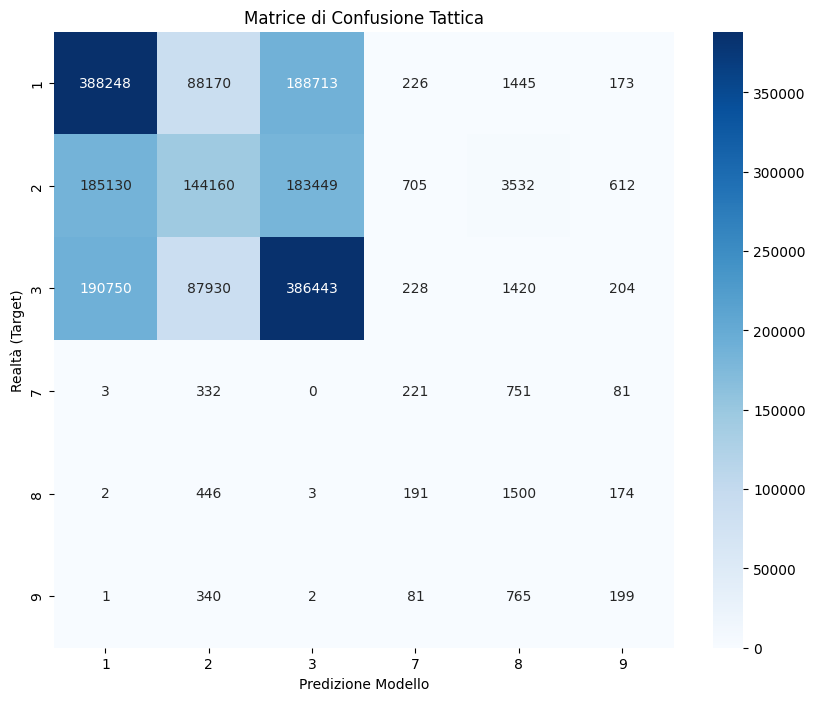


--- Report Classificazione ---
              precision    recall  f1-score   support

           1       0.51      0.58      0.54    666975
           2       0.45      0.28      0.34    517588
           3       0.51      0.58      0.54    666975
           7       0.13      0.16      0.15      1388
           8       0.16      0.65      0.26      2316
           9       0.14      0.14      0.14      1388

    accuracy                           0.50   1856630
   macro avg       0.32      0.40      0.33   1856630
weighted avg       0.49      0.50      0.49   1856630



In [82]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

def analyze_tactics(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    print("Calcolo metriche su tutto il dataset...")
    with torch.no_grad():
        for batch in loader:
            x_z = batch['x_zone'].to(DEVICE)
            x_t = batch['x_type'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            x_s = batch['x_s_id'].to(DEVICE)
            x_r = batch['x_r_id'].to(DEVICE)
            y = batch['y_target'].to(DEVICE)
            
            logits = model(x_z, x_t, x_c, x_s, x_r)
            
            # Mask Padding (same as before)
            mask = (y != 0).view(-1)
            
            preds = logits.argmax(dim=-1).view(-1)[mask]
            targets = y.view(-1)[mask]
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Definiamo le classi attese (Zone 1-9)
    expected_labels = [1, 2, 3, 7, 8, 9]
    target_names = [str(i) for i in expected_labels]

    # 1. Matrice di Confusione
    cm = confusion_matrix(all_targets, all_preds, labels=expected_labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predizione Modello')
    plt.ylabel('Realtà (Target)')
    plt.title('Matrice di Confusione Tattica')
    plt.show()
    
    # 2. Report
    print("\n--- Report Classificazione ---")
    print(classification_report(all_targets, all_preds, labels=expected_labels, target_names=target_names, zero_division=0))

# Esegui
analyze_tactics(model, full_loader, DEVICE)

### Data Augmentation with player embeddings 64, custom learning rate and 10 epochs:
```
              precision    recall  f1-score   support

           1       0.51      0.58      0.54    666975
           2       0.45      0.28      0.34    517588
           3       0.51      0.58      0.54    666975
           7       0.13      0.16      0.15      1388
           8       0.16      0.65      0.26      2316
           9       0.14      0.14      0.14      1388

    accuracy                           0.50   1856630
   macro avg       0.32      0.40      0.33   1856630
weighted avg       0.49      0.50      0.49   1856630
```
### Data Augmentation with player embeddings 64 and 20 epochs:
```
             precision    recall  f1-score   support

           1       0.51      0.59      0.54    666975
           2       0.44      0.30      0.35    517588
           3       0.51      0.56      0.53    666975
           7       0.18      0.13      0.15      1388
           8       0.17      0.40      0.24      2316
           9       0.12      0.34      0.18      1388

    accuracy                           0.50   1856630
   macro avg       0.32      0.39      0.33   1856630
weighted avg       0.49      0.50      0.49   1856630
```
### Data augmentation
```
              precision    recall  f1-score   support

           1       0.51      0.55      0.53    666975
           2       0.44      0.30      0.35    517588
           3       0.50      0.59      0.54    666975
           7       0.13      0.24      0.17      1388
           8       0.17      0.48      0.25      2316
           9       0.11      0.33      0.17      1388

    accuracy                           0.49   1856630
   macro avg       0.31      0.41      0.33   1856630
weighted avg       0.49      0.49      0.48   1856630
```
### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 16 anmd focal loss and 10 epochs:
```
             precision    recall  f1-score   support

           1       0.46      0.56      0.51    285103
           2       0.45      0.27      0.33    258794
           3       0.53      0.59      0.56    381872
           7       0.07      0.00      0.00       627
           8       0.14      0.65      0.24      1158
           9       0.14      0.36      0.20       761

    accuracy                           0.49    928315
   macro avg       0.30      0.40      0.31    928315
weighted avg       0.49      0.49      0.48    928315
```

### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 16 anmd focal loss and 20 epochs:
```
              precision    recall  f1-score   support

           1       0.48      0.53      0.50    285103
           2       0.45      0.27      0.34    258794
           3       0.53      0.62      0.57    381872
           7       0.12      0.02      0.04       627
           8       0.15      0.71      0.25      1158
           9       0.15      0.28      0.20       761

    accuracy                           0.49    928315
   macro avg       0.31      0.41      0.32    928315
weighted avg       0.49      0.49      0.48    928315
```
### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 16 anmd focal loss:
```
             precision    recall  f1-score   support

           1       0.48      0.49      0.49    285103
           2       0.43      0.34      0.38    258794
           3       0.53      0.59      0.56    381872
           7       0.10      0.17      0.13       627
           8       0.15      0.70      0.25      1158
           9       0.25      0.05      0.09       761

    accuracy                           0.49    928315
   macro avg       0.32      0.39      0.31    928315
weighted avg       0.49      0.49      0.49    928315
```

### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 64:
```
              precision    recall  f1-score   support

           1       0.48      0.50      0.49    285103
           2       0.45      0.28      0.34    258794
           3       0.52      0.65      0.58    381872
           7       0.25      0.01      0.02       627
           8       0.15      0.44      0.23      1158
           9       0.16      0.22      0.18       761

    accuracy                           0.50    928315
   macro avg       0.34      0.35      0.31    928315
weighted avg       0.49      0.50      0.48    928315
```
### Masked, smoothed 0.5 inverse frequency weights with PLAYER EMBEDDINGS:
```
              precision    recall  f1-score   support

           1       0.46      0.60      0.52    285103
           2       0.45      0.25      0.32    258794
           3       0.54      0.56      0.55    381872
           7       0.07      0.13      0.09       627
           8       0.13      0.93      0.23      1158
           9       0.45      0.01      0.03       761

    accuracy                           0.49    928315
   macro avg       0.35      0.42      0.29    928315
weighted avg       0.49      0.49      0.48    928315
```
### Masked, smoothed inverse frequency weights
```
              precision    recall  f1-score   support

           1       0.48      0.49      0.48    285103
           2       0.45      0.25      0.32    258794
           3       0.52      0.66      0.58    381872
           7       0.08      0.58      0.13       627
           8       0.16      0.41      0.23      1158
           9       0.14      0.28      0.18       761

    accuracy                           0.49    928315
   macro avg       0.30      0.44      0.32    928315
weighted avg       0.49      0.49      0.48    928315

```
### Masked
```
              precision    recall  f1-score   support

           1       0.48      0.53      0.50    285103
           2       0.49      0.19      0.27    258794
           3       0.51      0.68      0.59    381872
           7       0.20      0.00      0.00       627
           8       0.18      0.27      0.22      1158
           9       0.27      0.06      0.10       761

    accuracy                           0.50    928315
   macro avg       0.35      0.29      0.28    928315
weighted avg       0.49      0.50      0.47    928315
```
### 0.1 Custom weights, L/R, men dataset, 80/20:
```
              precision    recall  f1-score   support

           1       0.85      0.87      0.86    285103
           2       0.99      0.87      0.93    258794
           3       0.87      0.92      0.89    381872
           7       1.00      0.98      0.99       627
           8       1.00      0.99      0.99      1158
           9       0.96      0.99      0.98       761

    accuracy                           0.89    928315
   macro avg       0.94      0.94      0.94    928315
weighted avg       0.90      0.89      0.89    928315
```
### Custom weights, L/R, men dataset, group k fold:
```
--- Report Classificazione ---
              precision    recall  f1-score   support

           1       0.81      0.92      0.86    285103
           2       0.98      0.88      0.93    258794
           3       0.91      0.88      0.89    381872
           7       1.00      0.97      0.98       627
           8       0.97      0.99      0.98      1158
           9       0.99      0.97      0.98       761

    accuracy                           0.89    928315
   macro avg       0.94      0.93      0.94    928315
weighted avg       0.90      0.89      0.89    928315
```



In [83]:
def check_tactical_intelligence(model, loader):
    model.eval()
    correct_top3 = 0
    total = 0
    
    # Track "Winner" confusion (Zone 7, 8, 9)
    # Did we predict a winner (7,8,9) when the result was a winner (7,8,9)?
    winner_zones = {7, 8, 9}
    winner_correct = 0
    winner_total = 0
    
    with torch.no_grad():
        for batch in loader:
            x_z = batch['x_zone'].to(DEVICE)
            x_t = batch['x_type'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            x_s = batch['x_s_id'].to(DEVICE)
            x_r = batch['x_r_id'].to(DEVICE)
            y = batch['y_target'].to(DEVICE)
            
            logits = model(x_z, x_t, x_c, x_s, x_r)
            
            # 1. Top-3 Accuracy
            _, top3 = logits.topk(3, dim=-1)
            mask = (y != 0)
            hits = top3.eq(y.unsqueeze(-1)).any(dim=-1)
            correct_top3 += hits[mask].sum().item()
            
            # 2. Tactical Grouping Accuracy
            preds = logits.argmax(dim=-1)
            # Check only indices where the TRUE target was a winner zone
            for i in range(y.shape[0]):
                for t in range(y.shape[1]):
                    if y[i,t].item() in winner_zones:
                        winner_total += 1
                        if preds[i,t].item() in winner_zones:
                            winner_correct += 1
            
            total += mask.sum().item()

    print(f"Top-3 Accuracy: {correct_top3/total*100:.2f}%")
    if winner_total > 0:
        print(f"Winner Detection Rate (Pred 7/8/9 when True 7/8/9): {winner_correct/winner_total*100:.2f}%")

def calculate_directional_accuracy(model, loader, device):
    model.eval()
    correct_dir = 0
    total = 0
    
    # Define Mappings
    # Left: 1, 4, 7 | Center: 2, 5, 8 | Right: 3, 6, 9
    # We map 0->0, 1->1, 2->2, 3->3, 4->1, 5->2, ...
    dir_map = {0:0, 1:1, 4:1, 7:1,  2:2, 5:2, 8:2,  3:3, 6:3, 9:3, 10:0}
    
    with torch.no_grad():
        for batch in loader:
            x_z = batch['x_zone'].to(device)
            x_t = batch['x_type'].to(device)
            x_c = batch['context'].to(device)
            x_s = batch['x_s_id'].to(device)
            x_r = batch['x_r_id'].to(device)
            y = batch['y_target'].to(device)
            
            logits = model(x_z, x_t, x_c, x_s, x_r)
            preds = logits.argmax(dim=-1)
            
            # Filter Padding
            mask = (y != 0)
            y_real = y[mask].cpu().numpy()
            p_real = preds[mask].cpu().numpy()
            
            # Map to Directions
            y_dir = [dir_map.get(i, 0) for i in y_real]
            p_dir = [dir_map.get(i, 0) for i in p_real]
            
            # Compare
            correct_dir += np.sum(np.array(y_dir) == np.array(p_dir))
            total += len(y_dir)
            
    print(f"Directional Accuracy (L/C/R): {correct_dir/total*100:.2f}%")

calculate_directional_accuracy(model, full_loader, DEVICE)
check_tactical_intelligence(model, val_loader)

Directional Accuracy (L/C/R): 49.83%
Top-3 Accuracy: 99.40%
Winner Detection Rate (Pred 7/8/9 when True 7/8/9): 72.55%


### Data Augmentation with player embeddings 64, custom learning rate and 10 epochs:
```
Directional Accuracy (L/C/R): 49.83%
Top-3 Accuracy: 99.40%
Winner Detection Rate (Pred 7/8/9 when True 7/8/9): 72.55%
```

### Data Augmentation with player embeddings 64 and 20 epochs:
```
Directional Accuracy (L/C/R): 49.76%
Top-3 Accuracy: 99.48%
Winner Detection Rate (Pred 7/8/9 when True 7/8/9): 58.92%
```

### Data augmentation
```
Top-3 Accuracy: 99.32%
Winner Detection Rate (Pred 7/8/9 when True 7/8/9): 75.10%
```
### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 16 anmd focal loss and 10 epochs:
```
Directional Accuracy (L/C/R): 49.28%
Top-3 Accuracy: 99.39%
Winner Detection Rate (Pred 7/8/9 when True 7/8/9): 81.66%
```

### Masked, smoothed 0.3 inverse frequency weights with PLAYER EMBEDDINGS 16 anmd focal loss and 20 epochs:
```
Directional Accuracy (L/C/R): 49.68%
Top-3 Accuracy: 99.41%
Winner Detection Rate (Pred 7/8/9 when True 7/8/9): 81.78%
```

In [ ]:
def predict_next_shot(rally_str, surface='Hard', score='0-0', is_second_serve=False, server_hand='R', receiver_hand='R'):
    """
    New optional args: server_hand='R' or 'L', receiver_hand='R' or 'L'
    """
    # 1. Parsing (Unchanged)
    shots = rally_str.split(' ')
    seq_z, seq_t = [], []
    
    shot_vocab = dataset.shot_vocab
    zone_vocab = dataset.zone_vocab
    pattern = re.compile(r'([0-9]*)([a-zA-Z])([0-9]*)')
    
    last_tgt = 0
    for s in shots:
        m = pattern.search(s)
        if not m: continue
        ac, sc, tc = m.groups()
        
        arr = zone_vocab.get(ac, 0) if ac else last_tgt
        typ = shot_vocab.get(sc.lower(), 0)
        tgt = zone_vocab.get(tc, 0) if tc else 0
        last_tgt = tgt
        
        if typ != 0:
            seq_z.append(arr)
            seq_t.append(typ)
    
    # 2. Tensor Prep (Unchanged)
    L = len(seq_z)
    pad_len = SEQ_LEN - L
    if pad_len < 0: 
        seq_z = seq_z[-SEQ_LEN:]
        seq_t = seq_t[-SEQ_LEN:]
        pad_len = 0
        
    inp_z = torch.tensor([0]*pad_len + seq_z, dtype=torch.long).unsqueeze(0).to(DEVICE)
    inp_t = torch.tensor([0]*pad_len + seq_t, dtype=torch.long).unsqueeze(0).to(DEVICE)
    
    # 3. Context Prep (Updated for 6 Features)
    surf_idx = dataset.surface_vocab.get(surface, 1)
    
    try:
        s_srv, s_rcv = score.split('-')
        score_server = dataset.score_map.get(s_srv, 0)
        score_receiver = dataset.score_map.get(s_rcv, 0)
    except:
        score_server, score_receiver = 0, 0
        
    is_2nd = 1 if is_second_serve else 0
    
    # --- NEW: Handedness Mapping ---
    s_hand_idx = dataset.hand_vocab.get(server_hand, 1) # Default 1 (Right)
    r_hand_idx = dataset.hand_vocab.get(receiver_hand, 1) # Default 1 (Right)
    
    # Vector size is now 6: [Surf, Sc1, Sc2, 2nd, Hand1, Hand2]
    context_vec = [surf_idx, score_server, score_receiver, is_2nd, s_hand_idx, r_hand_idx]
    inp_c = torch.tensor([context_vec], dtype=torch.float32).to(DEVICE)
    
    # 4. Predict (Unchanged)
    model.eval()
    with torch.no_grad():
        logits = model(inp_z, inp_t, inp_c) 
        probs = torch.softmax(logits[0, -1, :], dim=0)
        
    # 5. Output
    print(f"\nScambio: {rally_str}")
    print(f"Ctx: {surface} | {score} | {server_hand} v {receiver_hand}")
    
    idx_to_zone = {v: k for k, v in zone_vocab.items()}
    top_probs, top_idxs = torch.topk(probs, 3)
    
    for p, idx in zip(top_probs, top_idxs):
        idx = idx.item()
        if idx == 0: continue
        print(f"Zona {idx_to_zone.get(idx, '?')}: {p.item()*100:.1f}%")

# --- Test Scenarios ---
print("Test 1: Standard Hard Court")
predict_next_shot("6s 2f") 

print("\nTest 2: Pressure Point on Clay (Longer rallies expected?)")
predict_next_shot("4s 1f 4b 3f", surface='Clay', score='30-40') 

print("\nTest 3: 2nd Serve Return")
predict_next_shot("5s", surface='Grass', is_second_serve=True)

### STANDALONE DEMO PER IL CLONE

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import random
from torch.utils.data import Dataset

# --- 1. SETUP & DATASET ---
points_path = '/kaggle/input/tennis-match-charting-project/charting-m-points.csv' 
matches_path = '/kaggle/input/tennis-match-charting-project/charting-m-matches.csv'
atp_path = '/kaggle/input/atp-players/atp_players.csv'
wta_path = '/kaggle/input/wta-players/wta_players.csv'
SEQ_LEN = 30
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class MCPTennisDataset(Dataset):
    def __init__(self, points_path, matches_path, atp_path, wta_path, max_seq_len=30):
        self.max_seq_len = max_seq_len
        print("Initializing Dataset...")
        self.name_to_hand = self._load_handedness(atp_path, wta_path)
        try:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
        except:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', quoting=3)
        self.match_meta = self._process_match_metadata(self.matches_df)
        try:
            self.df = pd.read_csv(points_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
        except:
            self.df = pd.read_csv(points_path, encoding='ISO-8859-1', quoting=3)
        
        self.shot_vocab = {'<pad>': 0, 'f': 1, 'b': 2, 'r': 3, 'v': 4, 'o': 5, 's': 6, 'u': 7, 'l': 8, 'm': 9, 'z': 10}
        self.zone_vocab = {'<pad>': 0, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
        self.surface_vocab = {'<pad>': 0, 'Hard': 1, 'Clay': 2, 'Grass': 3, 'Carpet': 4}
        self.hand_vocab = {'<pad>': 0, 'R': 1, 'L': 2} 
        self.score_map = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}
        
        self.samples = []
        self.sample_match_ids = [] 
        self.process_data()

    def _load_handedness(self, atp_path, wta_path):
        hand_map = {}
        for path in [atp_path, wta_path]:
            if not os.path.exists(path): continue
            try:
                df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
                df['full_name'] = df['name_first'].str.strip() + " " + df['name_last'].str.strip()
                subset = df[['full_name', 'hand']].dropna()
                for _, row in subset.iterrows():
                    hand_map[row['full_name']] = row['hand']
            except: pass
        return hand_map

    def _process_match_metadata(self, df):
        meta = {}
        for _, row in df.iterrows():
            m_id = row['match_id']
            surf = str(row.get('Surface', row.get('surface', 'Hard')))
            if 'Hard' in surf: surf = 'Hard'
            elif 'Clay' in surf: surf = 'Clay'
            elif 'Grass' in surf: surf = 'Grass'
            else: surf = 'Hard'
            p1 = str(row.get('Player1', row.get('player1', '')))
            p2 = str(row.get('Player2', row.get('player2', '')))
            meta[m_id] = {'surface': surf, 'p1_hand': self.name_to_hand.get(p1, 'R'), 'p2_hand': self.name_to_hand.get(p2, 'R')}
        return meta

    def process_data(self):
        print(f"Parsing rallies...")
        shot_pattern = re.compile(r'([0-9]*)([a-zA-Z])([0-9]*)')
        for _, row in self.df.iterrows():
            match_id = row['match_id']
            rally_str = str(row['2nd']) if pd.notna(row['2nd']) else str(row['1st'])
            if pd.isna(rally_str) or rally_str == 'nan': continue

            m_meta = self.match_meta.get(match_id, {'surface': 'Hard', 'p1_hand': 'R', 'p2_hand': 'R'})
            surf_idx = self.surface_vocab.get(m_meta['surface'], 1)
            sc_s, sc_r = 0, 0
            if 'Pts' in row and isinstance(row['Pts'], str):
                try:
                    parts = row['Pts'].split('-')
                    if len(parts) == 2:
                        sc_s = self.score_map.get(parts[0], 0)
                        sc_r = self.score_map.get(parts[1], 0)
                except: pass
            
            svr = row['Svr'] if 'Svr' in row else 1
            if svr == 2: s_hand, r_hand = m_meta['p2_hand'], m_meta['p1_hand']
            else: s_hand, r_hand = m_meta['p1_hand'], m_meta['p2_hand']
            
            sh_idx = self.hand_vocab.get(s_hand, 1)
            rh_idx = self.hand_vocab.get(r_hand, 1)
            is_2nd = 1 if pd.notna(row['2nd']) else 0
            context_vec = [surf_idx, sc_s, sc_r, is_2nd, sh_idx, rh_idx]

            r_clean = re.sub(r'[@#n\*\!\+;]', '', rally_str)
            matches = shot_pattern.findall(r_clean)
            if len(matches) < 2: continue
            
            seq_arr, seq_typ, seq_tgt = [], [], []
            last_tgt = 0
            for m in matches:
                ac, sc, tc = m
                arr = self.zone_vocab.get(ac, 0) if ac else last_tgt
                typ = self.shot_vocab.get(sc.lower(), 0)
                tgt = self.zone_vocab.get(tc, 0) if tc else 0
                last_tgt = tgt
                if typ != 0:
                    seq_arr.append(arr); seq_typ.append(typ); seq_tgt.append(tgt)
            
            if len(seq_tgt) > 1:
                L = min(len(seq_arr), self.max_seq_len)
                pad = [0] * (self.max_seq_len - L)
                self.samples.append({
                    'x_zone': torch.tensor(pad + seq_arr[:L], dtype=torch.long),
                    'x_type': torch.tensor(pad + seq_typ[:L], dtype=torch.long),
                    'context': torch.tensor(context_vec, dtype=torch.float32),
                    'y_target': torch.tensor(pad + seq_tgt[:L], dtype=torch.long)
                })
                self.sample_match_ids.append(match_id)
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

if os.path.exists(points_path):
    dataset = MCPTennisDataset(points_path, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN)
else:
    print("Warning: Dataset files not found.")

# --- 2. MODEL DEFINITION & LOADING ---
class SymbolicTinyRM_Context(nn.Module):
    def __init__(self, zone_vocab_size, type_vocab_size, context_dim=6, embed_dim=64, n_head=4, n_cycles=3, seq_len=30):
        super().__init__()
        self.n_cycles = n_cycles
        self.zone_emb = nn.Embedding(zone_vocab_size, embed_dim)
        self.type_emb = nn.Embedding(type_vocab_size, embed_dim)
        self.context_mlp = nn.Sequential(
            nn.Linear(context_dim, embed_dim), nn.ReLU(), nn.Linear(embed_dim, embed_dim)
        )
        self.input_dim = embed_dim * 3
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, self.input_dim))
        self.shared_block = nn.TransformerEncoderLayer(
            d_model=self.input_dim, nhead=n_head, dim_feedforward=embed_dim * 8,
            batch_first=True, norm_first=True, dropout=0.1
        )
        self.norm_f = nn.LayerNorm(self.input_dim)
        self.head = nn.Linear(self.input_dim, zone_vocab_size)

    def forward(self, x_z, x_t, x_c):
        z = self.zone_emb(x_z); t = self.type_emb(x_t)
        c = self.context_mlp(x_c).unsqueeze(1).expand(-1, z.size(1), -1)
        x = torch.cat([z, t, c], dim=-1)
        x = x + self.pos_emb[:, :x.size(1), :]
        memory = x.clone()
        for _ in range(self.n_cycles): memory = self.shared_block(memory)
        return self.head(self.norm_f(memory))

# Load Model
model_path = '/kaggle/input/test/pytorch/default/1/tennis_shot_forecasting.pth'

loaded_model = SymbolicTinyRM_Context(
    zone_vocab_size=len(dataset.zone_vocab),
    type_vocab_size=len(dataset.shot_vocab),
    context_dim=6, 
    seq_len=SEQ_LEN
).to(DEVICE)

if os.path.exists(model_path):
    loaded_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    loaded_model.eval()
    print(f"✅ Model loaded from {model_path}!")
else:
    print("⚠️ Saved model not found. Using untrained weights.")

# --- 3. CORRECTED TEXT-ONLY PROOF (Mid-Rally) ---
def prove_mid_rally(model, dataset, num_samples=5, min_rally_len=4):
    print(f"\n--- Testing {num_samples} Mid-Rally Shots ---")
    
    idx2zone = {v: k for k, v in dataset.zone_vocab.items()}
    idx2shot = {v: k for k, v in dataset.shot_vocab.items()}
    
    candidates = []
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    
    # Find candidates
    for i in indices:
        if torch.count_nonzero(dataset[i]['x_zone']).item() >= min_rally_len:
            candidates.append(i)
        if len(candidates) >= num_samples * 2: # Get extra to allow for invalid steps
            break
            
    correct_count = 0
    valid_tests = 0
    
    for sample_idx in candidates:
        if valid_tests >= num_samples: break
        
        sample = dataset[sample_idx]
        
        inp_z = sample['x_zone'].unsqueeze(0).to(DEVICE)
        inp_t = sample['x_type'].unsqueeze(0).to(DEVICE)
        inp_c = sample['context'].unsqueeze(0).to(DEVICE)
        y_tgt = sample['y_target'].to(DEVICE)
        
        # Identify Non-Padding Indices
        non_pad_indices = (sample['x_zone'] != 0).nonzero(as_tuple=True)[0].tolist()
        
        if len(non_pad_indices) < 2: continue
        
        # Try to find a step where the target is NOT 0
        valid_steps = [idx for idx in non_pad_indices if y_tgt[idx].item() != 0]
        
        if not valid_steps: continue
        
        test_step_idx = random.choice(valid_steps)
        
        # Reconstruct History UP TO that point
        history_parts = []
        for i in non_pad_indices:
            if i > test_step_idx: break 
            z = idx2zone.get(sample['x_zone'][i].item(), '?')
            t = idx2shot.get(sample['x_type'][i].item(), '?')
            history_parts.append(f"{z}{t}")
            
        history_str = " ".join(history_parts)
        
        with torch.no_grad():
            logits = model(inp_z, inp_t, inp_c)
            pred_idx = logits[0, test_step_idx, :].argmax().item()
            true_idx = y_tgt[test_step_idx].item()
            if true_idx in [2, 3]: continue # Skip the easy/common shots OPTIONAL/REMOVE
            
        pred_zone = idx2zone.get(pred_idx, '?')
        true_zone = idx2zone.get(true_idx, '?')
        
        is_correct = (pred_zone == true_zone)
        if is_correct: correct_count += 1
        valid_tests += 1
        
        status = "✅ CORRECT" if is_correct else "❌ MISS   "
        
        print(f"\nMatch ID: {dataset.sample_match_ids[sample_idx]}")
        print(f"Partial Rally: {history_str} ... [PREDICT NEXT]")
        print(f"{status} | Predicted Zone: {pred_zone} | Actual Zone: {true_zone}")

    if valid_tests > 0:
        print(f"\nFinal Score: {correct_count}/{valid_tests} ({correct_count/valid_tests*100:.1f}%)")
    else:
        print("\nNo valid mid-rally targets found.")

# --- 4. EXECUTE ---
prove_mid_rally(loaded_model, dataset, num_samples=10, min_rally_len=3)

It correctly predicts all zone 2/3 shots, but for zone 1 it has some misses (understandable). With L/R recognition the situation improved for misses on 1. 

Interestingly enough, if we use the women's model on the men's dataset, we get improved accuracy on zone 1 shots but reduced accuracy on zone 2/3